# Case study

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
from zipfile import ZipFile # Important for GOME-2 L3 (TEMIS)

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run ../functions/functions_general.ipynb
%run ../functions/functions_cams.ipynb
%run ../functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'gome'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2010-01-01'
end_date = '2019-12-31'

# Define extent
area_name = 'Spain'
lon_min = -10
lon_max = 5
lat_min = 35
lat_max = 45

# Define resolution (Unique: 0.25x.0.25)
lat_res = 0.25
lon_res = 0.25

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '201

## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name,
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 14, longitude: 21, time: 120)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
    surface     float64 ...
  * latitude    (latitude) float64 35.0 35.75 36.5 37.25 ... 43.25 44.0 44.75
  * longitude   (longitude) float64 -10.0 -9.25 -8.5 -7.75 ... 2.75 3.5 4.25 5.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-21T20:34 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [10]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, column_type, 
                                lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be directly compared to the tropospheric sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 14, longitude: 21, time: 120)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
    surface     float64 0.0
  * latitude    (latitude) float64 35.0 35.75 36.5 37.25 ... 43.25 44.0 44.75
  * longitude   (longitude) float64 -10.0 -9.25 -8.5 -7.75 ... 2.75 3.5 4.25 5.0
    valid_time  (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    component   (time, latitude, longitude) float32 1.988e+15 ... 4.914e+15
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-21T20:34 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2010-01:
GOME_L3_NO2_COLUMN_METOP_A_201001.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201001.asc.zip is not available.
GOME_L3_NO2_COLUMN_METOP_A_201001.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201001.asc.zip is not available.
For 2010-02:
GOME_L3_NO2_COLUMN_METOP_A_201002.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201002.asc.zip is not available.
GOME_L3_NO2_COLUMN_METOP_A_201002.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201002.asc.zip is not available.
For 2010-03:
GOME_L3_NO2_COLUMN_METOP_A_201003.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201003.asc.zip is not available.
GOME_L3_NO2_COLUMN_METOP_A_201003.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201003.asc.zip is not available.
For 2010-04:
GOME_L3_NO2_COLUMN_METOP_A_201004.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201004.asc.zip is not available.
GOME_L3_NO2_COLUMN_METOP_A_201004.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201004.asc.zip is not availab

In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, 
                              dates, satellites, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 720, longitude: 1440, time: 120)
Coordinates:
  * longitude      (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude       (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    sensor_column  (longitude, latitude, time) float64 nan nan nan ... nan nan

## 4. Match data

In [13]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2010-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2010-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

latitude  longitude       time  sensor_column  model_column
0       34.875    -10.125 2010-01-01   5.000000e+14  1.988135e+15
1       34.875     -9.875 2010-01-01   6.300000e+14  1.988135e+15
2       34.875     -9.625 2010-01-01   6.000000e+14  2.198108e+15
3       34.875     -9.375 2010-01-01   7.400000e+14  2.198108e+15
4       34.875     -9.125 2010-01-01   7.500000e+14  2.198108e+15
...        ...        ...        ...            ...           ...
2496    44.875      3.875 2019-12-01   1.640000e+15  4.868217e+15
2497    44.875      4.125 2019-12-01   2.200000e+15  4.868217e+15
2498    44.875      4.375 2019-12-01   3.110000e+15  4.868217e+15
2499    44.875      4.625 2019-12-01   2.920000e+15  4.914247e+15
2500    44.875      4.875 2019-12-01   3.030000e+15  4.914247e+15

[300120 rows x 5 columns]

## 5. Merge data and calculate difference

In [14]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
34.875   -10.125   2010-01-01  1.988135e+15   5.000000e+14 -1.488135e+15   
         -9.875    2010-01-01  1.988135e+15   6.300000e+14 -1.358135e+15   
         -9.625    2010-01-01  2.198108e+15   6.000000e+14 -1.598108e+15   
         -9.375    2010-01-01  2.198108e+15   7.400000e+14 -1.458108e+15   
         -9.125    2010-01-01  2.198108e+15   7.500000e+14 -1.448108e+15   
...                                     ...            ...           ...   
44.875    3.875    2019-12-01  4.868217e+15   1.640000e+15 -3.228217e+15   
          4.125    2019-12-01  4.868217e+15   2.200000e+15 -2.668217e+15   
          4.375    2019-12-01  4.868217e+15   3.110000e+15 -1.758217e+15   
          4.625    2019-12-01  4.914247e+15   2.920000e+15 -1.994247e+15   
          4.875    2019-12-01  4.914247e+15   3.030000e+15 -1.884247e+15   

                               relative_difference  
latitude longitude time                             
34.875   -10.125   2010-01-01             2.976270  
         -9.875    2010-01-01             2.155770  
         -9.625    2010-01-01             2.663513  
         -9.375    2010-01-01             1.970416  
         -9.125    2010-01-01             1.930810  
...                                            ...  
44.875    3.875    2019-12-01             1.968425  
          4.125    2019-12-01             1.212826  
          4.375    2019-12-01             0.565343  
          4.625    2019-12-01             0.682961  
          4.875    2019-12-01             0.621864  

[300120 rows x 4 columns]

In [15]:
merge_df = merge_df.replace([np.inf, -np.inf], np.nan)
merge_df = merge_df[(merge_df['model_column'] >= 0) | (merge_df['model_column'].isnull())]
merge_df = merge_df[(merge_df['sensor_column'] >= 0) | (merge_df['sensor_column'].isnull())]

In [16]:
descr_stats_table = merge_df.describe()
descr_stats_table

model_column  sensor_column    difference  relative_difference
count  2.974900e+05   2.966690e+05  2.966690e+05        296630.000000
mean   3.450178e+15   2.097293e+15 -1.352210e+15             1.171495
std    9.020222e+14   1.033996e+15  9.875994e+14             5.590041
min    1.459781e+15   0.000000e+00 -1.034898e+16            -0.783544
25%    2.864145e+15   1.400000e+15 -1.870387e+15             0.380503
50%    3.262169e+15   1.900000e+15 -1.369048e+15             0.737972
75%    3.804469e+15   2.580000e+15 -8.798035e+14             1.241562
max    1.105717e+16   1.726000e+16  1.352397e+16           719.938285

## 6. Show comparison plots

### Select plot dates

In [17]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2010-01' '2010-02' '2010-03' '2010-04' '2010-05' '2010-06' '2010-07'
 '2010-08' '2010-09' '2010-10' '2010-11' '2010-12' '2011-01' '2011-02'
 '2011-03' '2011-04' '2011-05' '2011-06' '2011-07' '2011-08' '2011-09'
 '2011-10' '2011-11' '2011-12' '2012-01' '2012-02' '2012-03' '2012-04'
 '2012-05' '2012-06' '2012-07' '2012-08' '2012-09' '2012-10' '2012-11'
 '2012-12' '2013-01' '2013-02' '2013-03' '2013-04' '2013-05' '2013-06'
 '2013-07' '2013-08' '2013-09' '2013-10' '2013-11' '2013-12' '2014-01'
 '2014-02' '2014-03' '2014-04' '2014-05' '2014-06' '2014-07' '2014-08'
 '2014-09' '2014-10' '2014-11' '2014-12' '2015-01' '2015-02' '2015-03'
 '2015-04' '2015-05' '2015-06' '2015-07' '2015-08' '2015-09' '2015-10'
 '2015-11' '2015-12' '2016-01' '2016-02' '2016-03' '2016-04' '2016-05'
 '2016-06' '2016-07' '2016-08' '2016-09' '2016-10' '2016-11' '2016-12'
 '2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-1

### Select plot extent

In [18]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-10, 35), (5, 45))


### Compare CAMS and GOME-2 total columns

Frame length between -10 and 5 should be one of these options: [1, 3, 5, 15]
Frame length between 35 and 45 should be one of these options: [1, 2, 5, 10]


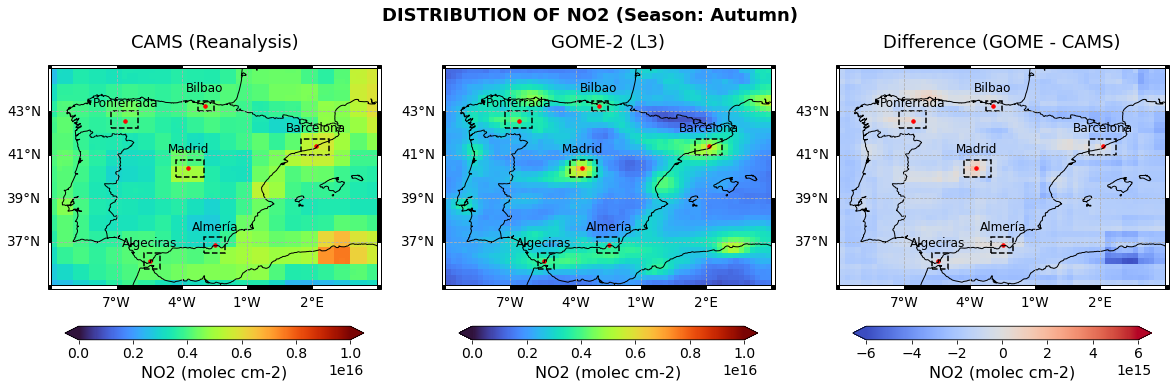

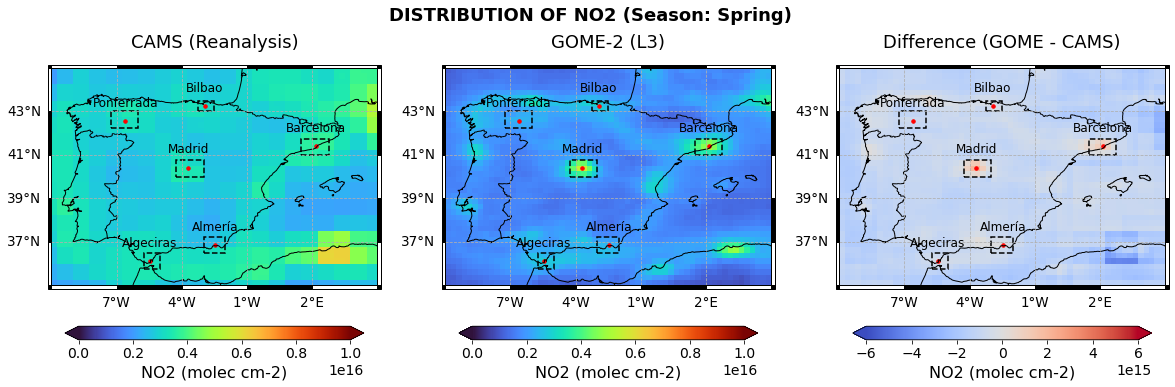

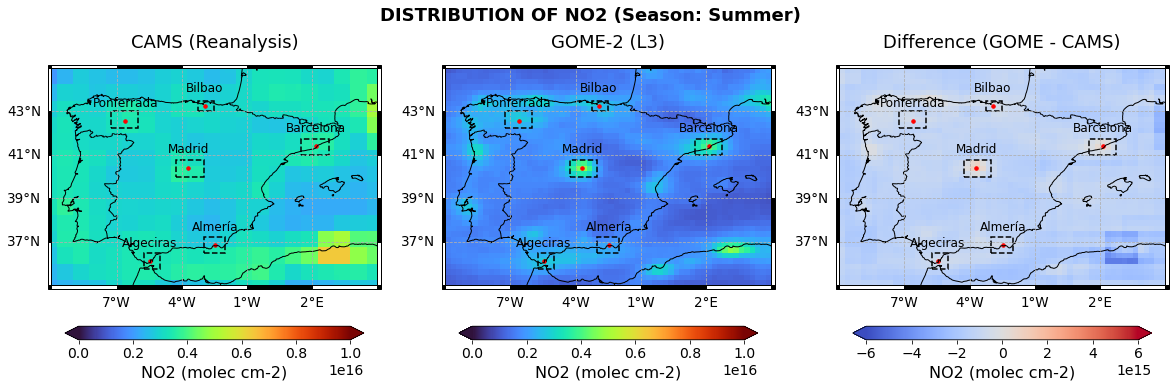

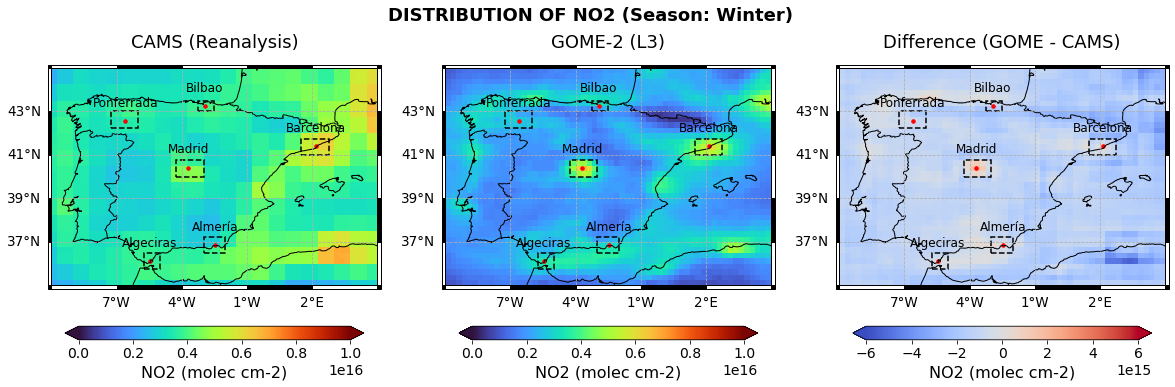

In [19]:
# Choose distribution (aggregated, individual, seasonal or animated)
distribution_type = 'seasonal'

# Define range (original, equal, centered or manual)
range_type = 'manual'
vmin_manual, vmax_manual = 0, 1*10**16
vmin_manual_diff, vmax_manual_diff = -6*10**15, 6*10**15

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 3
height_lat = 2

# Add markers
regions_names = ('Barcelona', 'Madrid', 'Bilbao', 'Ponferrada', 'Algeciras', 'Almería')
bbox_list = (41, 41.75, 1.5, 2.75,
             40, 40.75, -4.25, -3,
             43, 43.5, -3.25, -2.5,
             42.25, 43, -7.25, -6,
             35.75, 36.5, -5.75, -5,
             36.5, 37.25, -3, -2)
coords_list = (41.39, 2.15,
               40.42, -3.70,
               43.26, -2.94,
               42.55, -6.60,
               36.13, -5.46,
               36.84, -2.46)

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual, 
                          vmin_manual_diff, vmax_manual_diff, bbox_list, coords_list, regions_names)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region    lat_search lon_search latitude longitude time                       
Barcelona 41.39       2.15      41.375    2.125    2010-01-01  8.107516e+15   
                                                   2010-02-01  5.502975e+15   
                                                   2010-03-01  5.272762e+15   
                                                   2010-04-01  4.304994e+15   
                                                   2010-05-01  4.015569e+15   
...                                                                     ...   
Almería   36.84      -2.46      36.875   -2.375    2019-08-01  2.712146e+15   
                                                   2019-09-01  2.819273e+15   
                                                   2019-10-01  3.274071e+15   
                                                   2019-11-01  2.871321e+15   
                                                   2019-12-01  2.675088e+15   

                                                               sensor_column  \
region    lat_search lon_search latitude longitude time                        
Barcelona 41.39       2.15      41.375    2.125    2010-01-01   6.240000e+15   
                                                   2010-02-01   6.040000e+15   
                                                   2010-03-01   6.240000e+15   
                                                   2010-04-01   6.110000e+15   
                                                   2010-05-01   5.400000e+15   
...                                                                      ...   
Almería   36.84      -2.46      36.875   -2.375    2019-08-01   3.390000e+15   
                                                   2019-09-01   2.330000e+15   
                                                   2019-10-01   4.670000e+15   
                                                   2019-11-01   4.390000e+15   
                                                   2019-12-01   5.830000e+15   

                                                                 difference  \
region    lat_search lon_search latitude longitude time                       
Barcelona 41.39       2.15      41.375    2.125    2010-01-01 -1.867516e+15   
                                                   2010-02-01  5.370254e+14   
                                                   2010-03-01  9.672378e+14   
                                                   2010-04-01  1.805006e+15   
                                                   2010-05-01  1.384431e+15   
...                                                                     ...   
Almería   36.84      -2.46      36.875   -2.375    2019-08-01  6.778535e+14   
                                                   2019-09-01 -4.892732e+14   
                                                   2019-10-01  1.395929e+15   
                                                   2019-11-01  1.518679e+15   
                                                   2019-12-01  3.154912e+15   

                                                               relative_difference  
region    lat_search lon_search latitude longitude time                             
Barcelona 41.39       2.15      41.375    2.125    2010-01-01             0.299281  
                                                   2010-02-01            -0.088911  
                                                   2010-03-01            -0.155006  
                                                   2010-04-01            -0.295418  
                                                   2010-05-01            -0.256376  
...                                                                            ...  
Almería   36.84      -2.46      36.875   -2.375    2019-08-01            -0.199957  
                                                   2019-09-01             0.209988  
                                                   2019-10-01            -0.298914  
                               

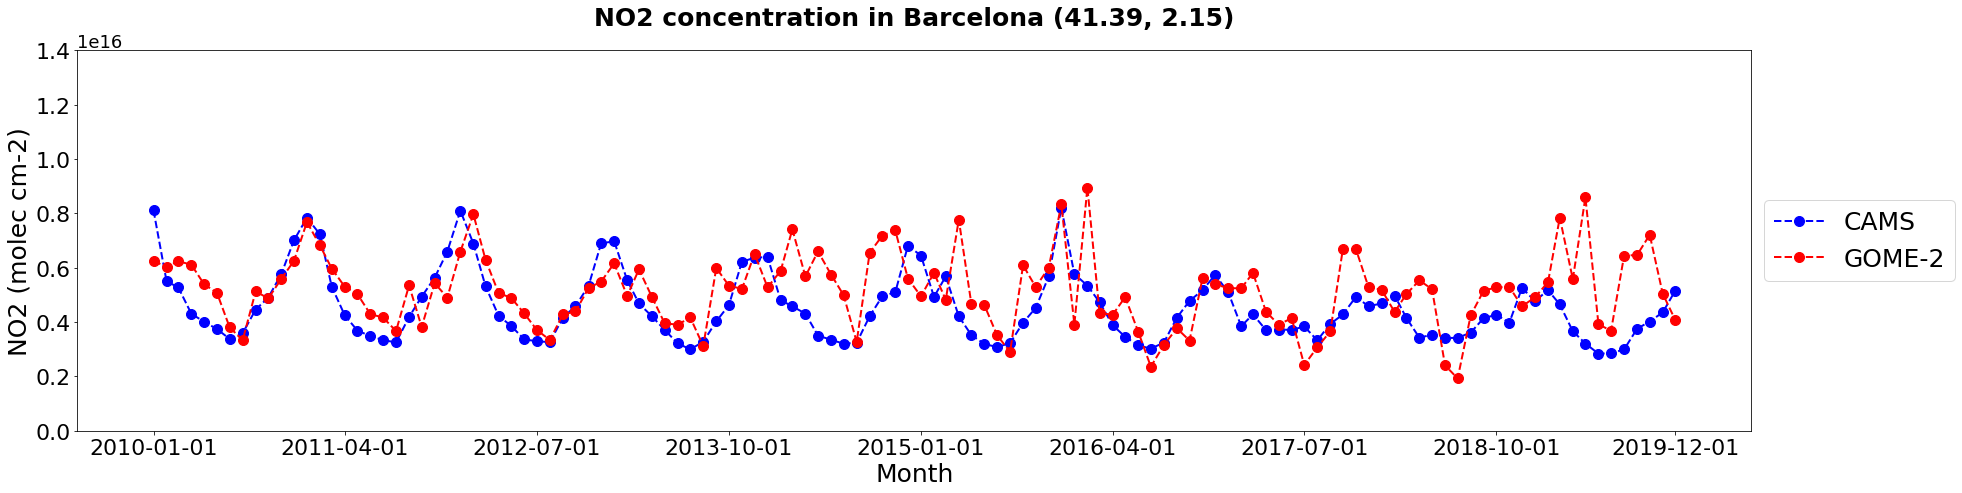

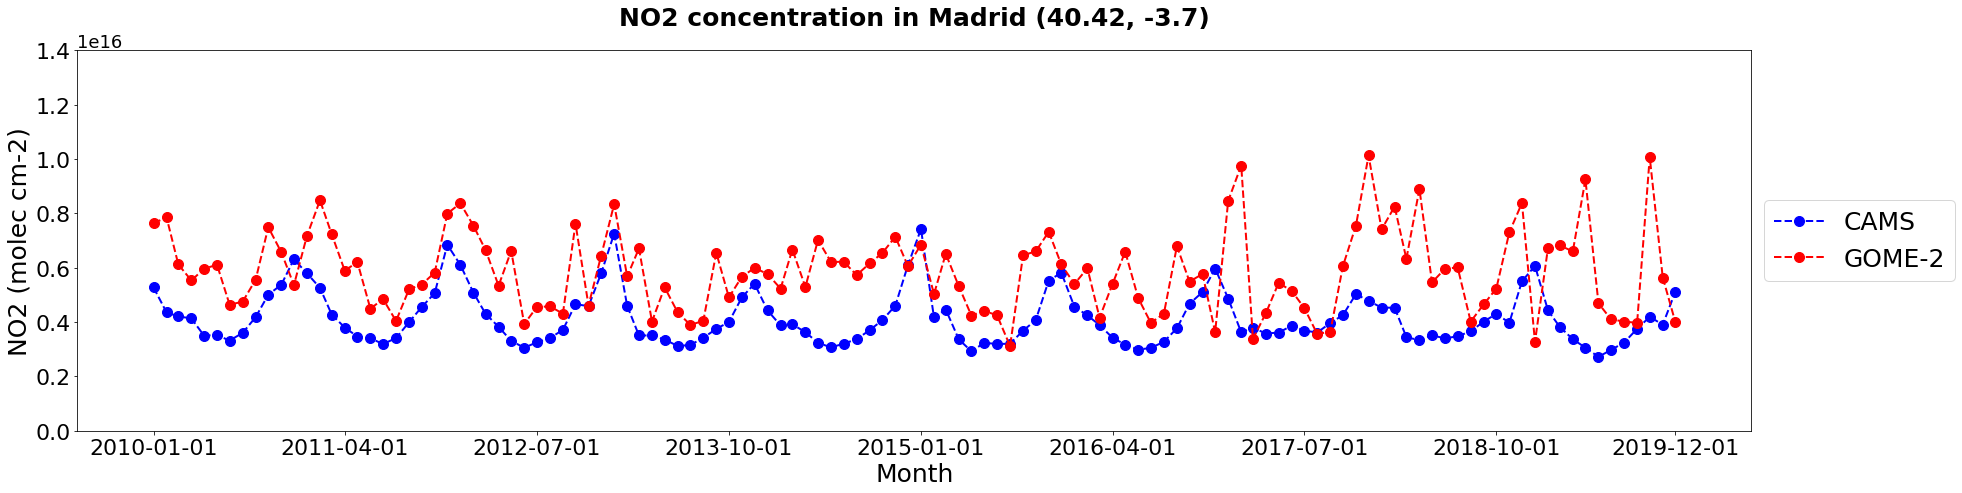

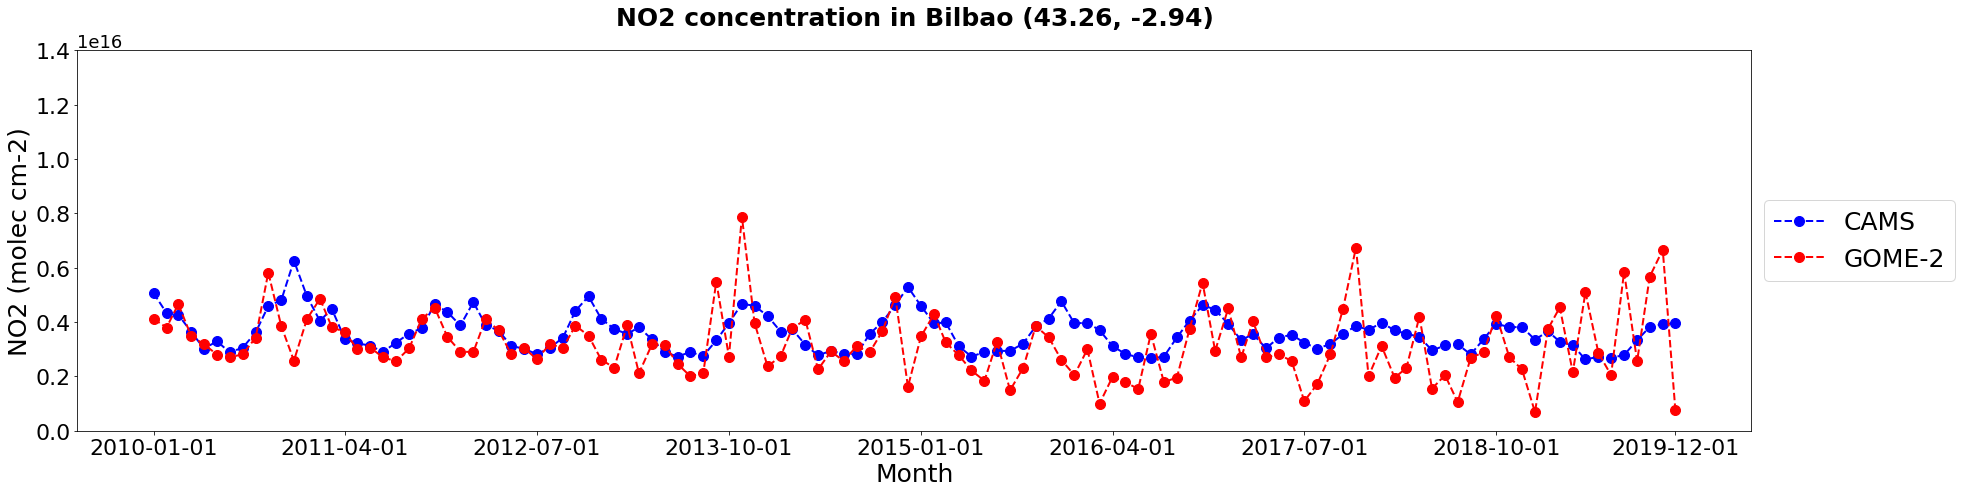

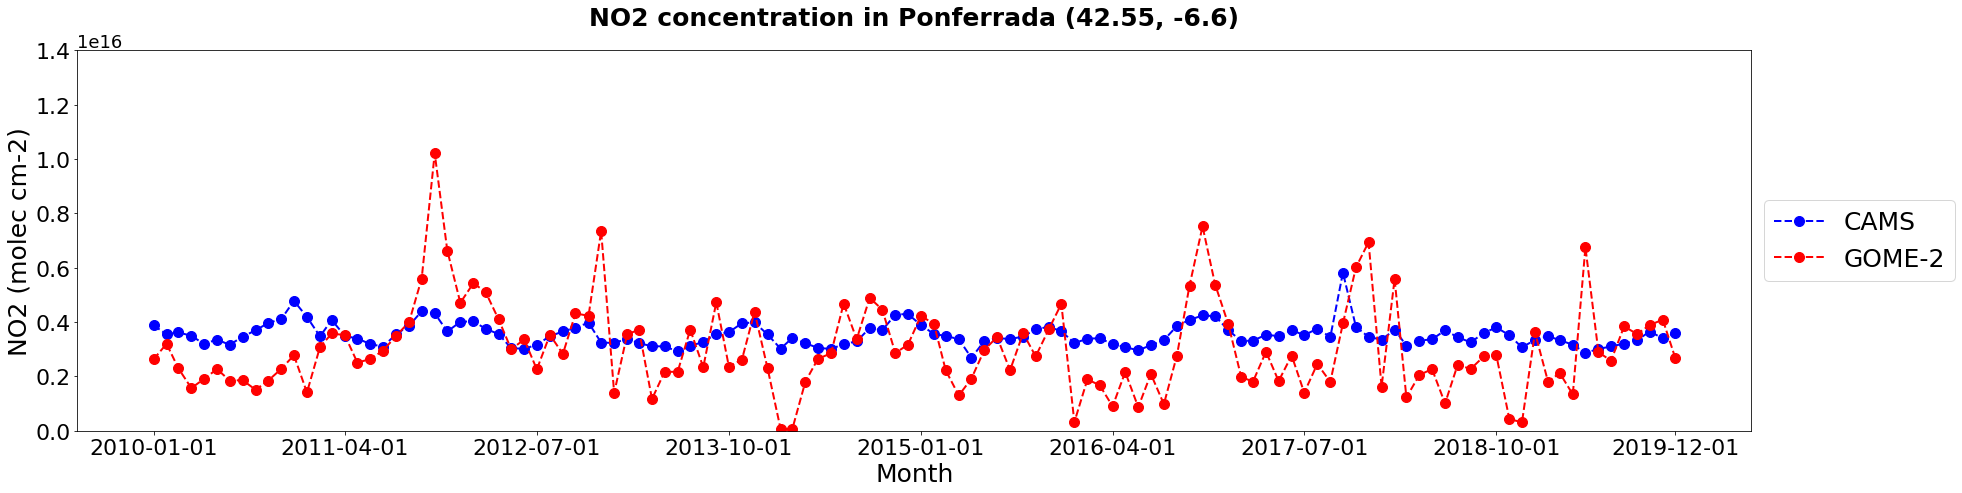

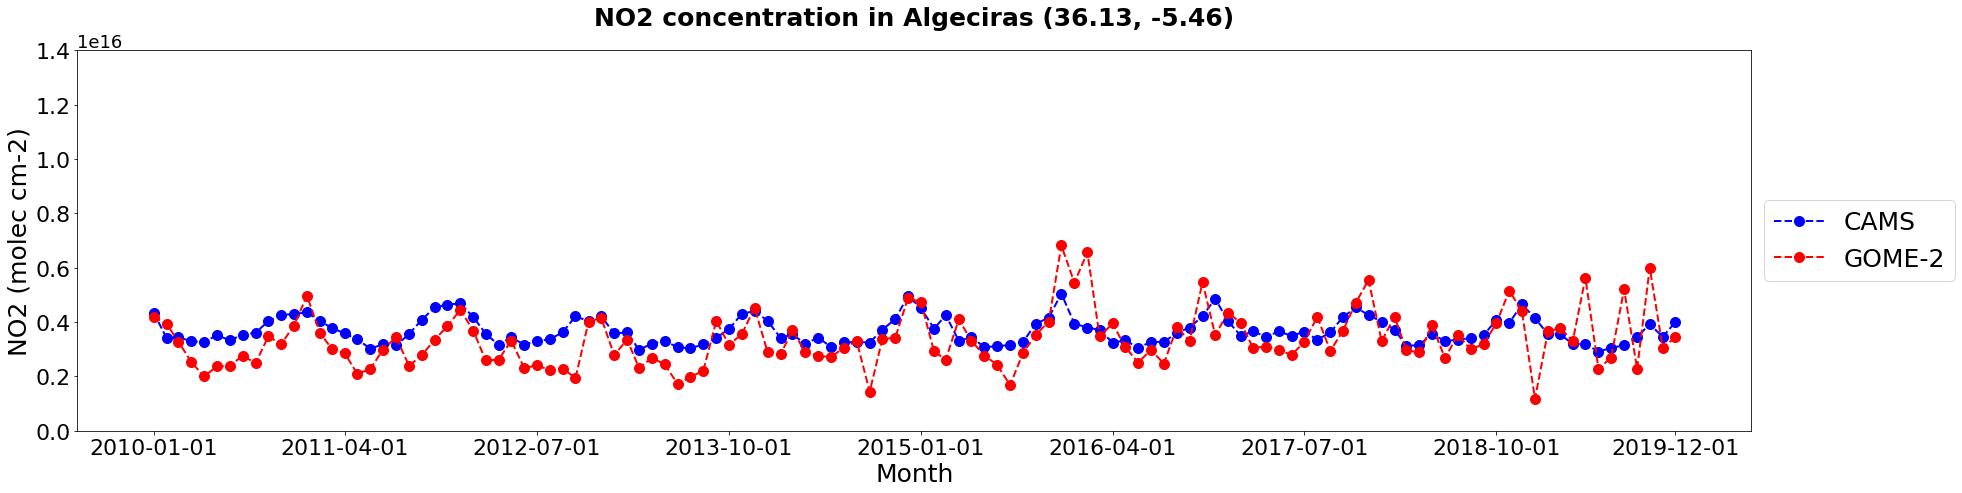

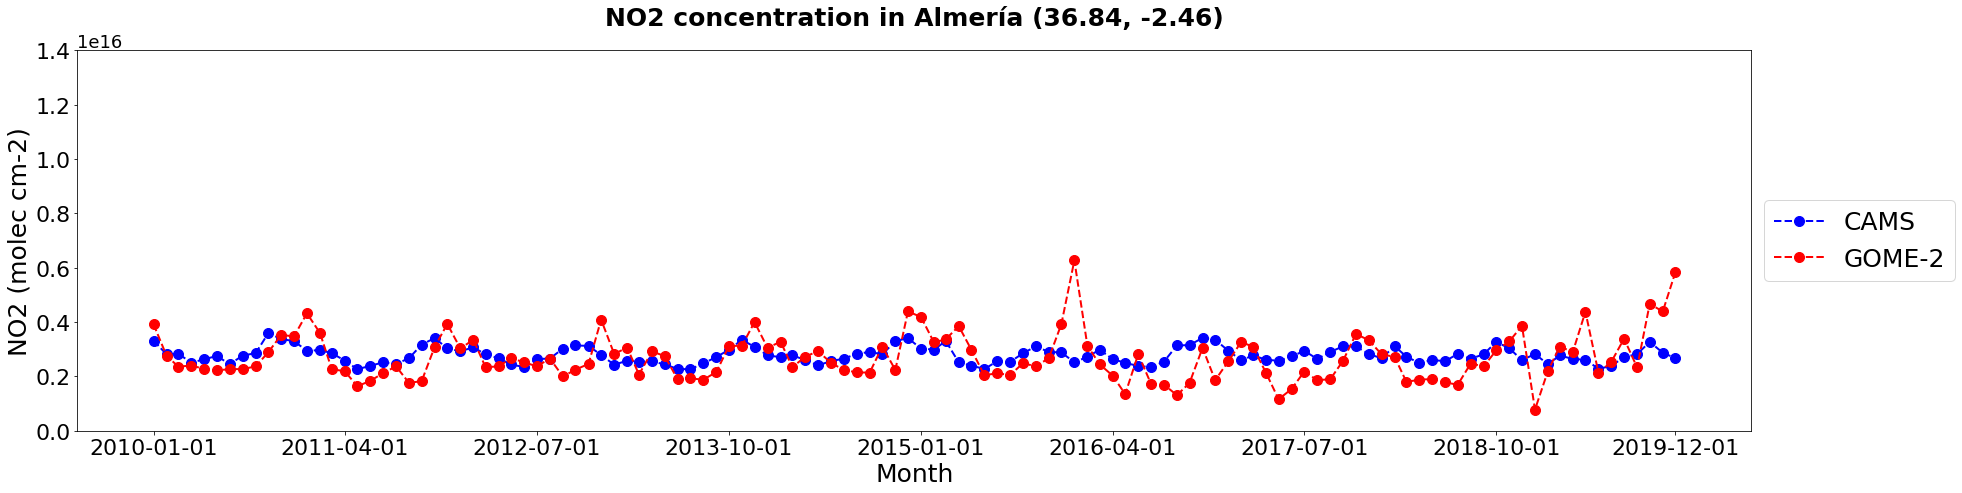

In [20]:
regions_names = ('Barcelona', 'Madrid', 'Bilbao', 'Ponferrada', 'Algeciras', 'Almería')
coords_list = (41.39, 2.15,
               40.42, -3.70,
               43.26, -2.94,
               42.55, -6.60,
               36.13, -5.46,
               36.84, -2.46)
ymin = 0
ymax = 1.4*10**16
xticks = np.append(plot_dates[0::15], plot_dates[-1])
timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

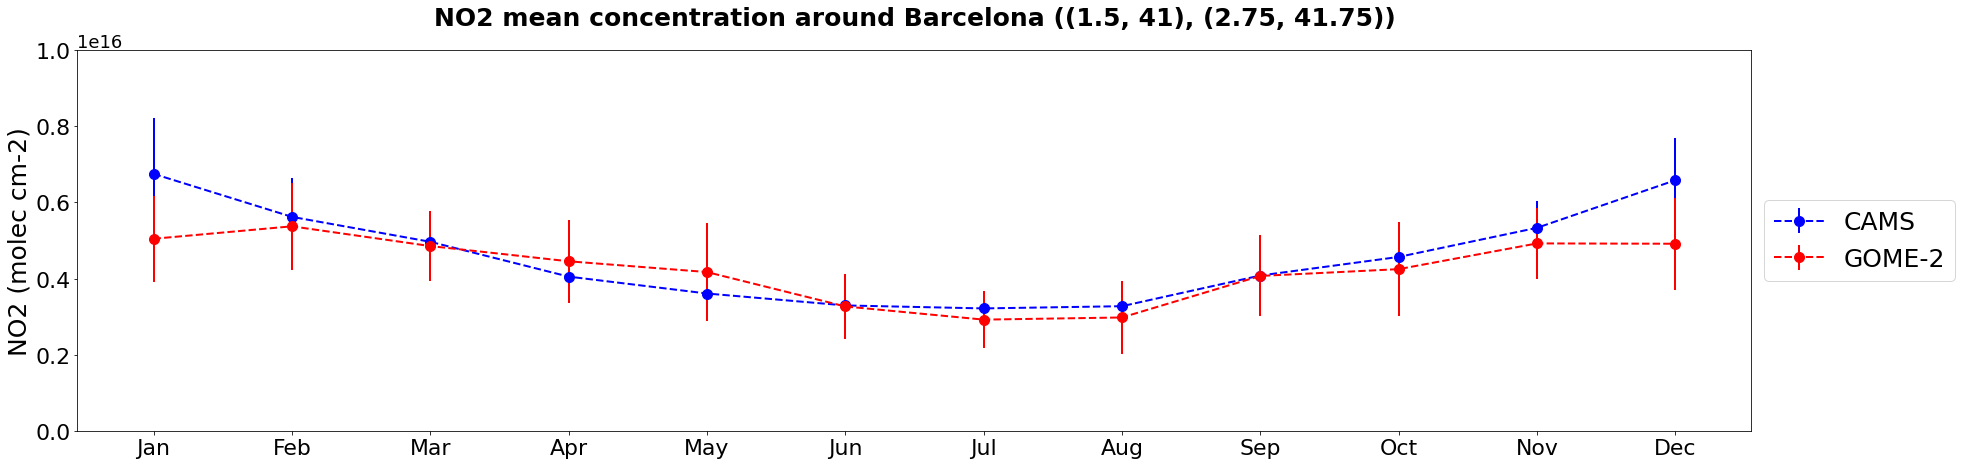

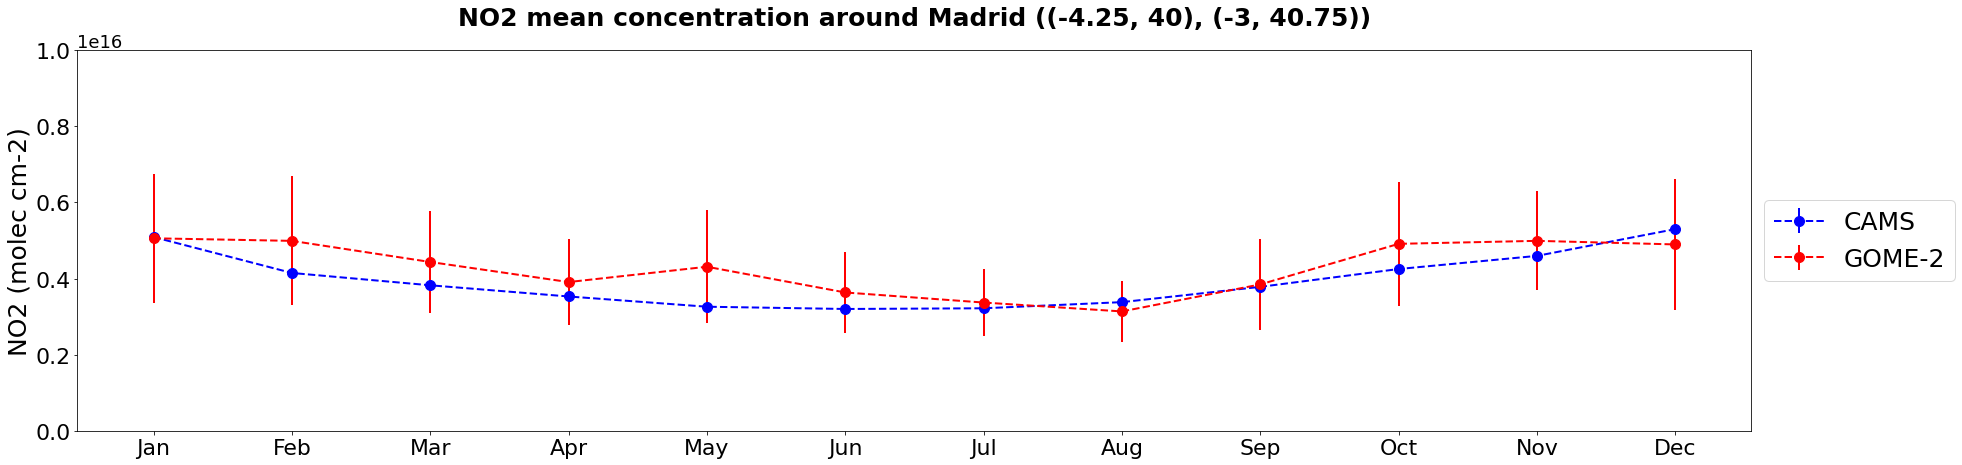

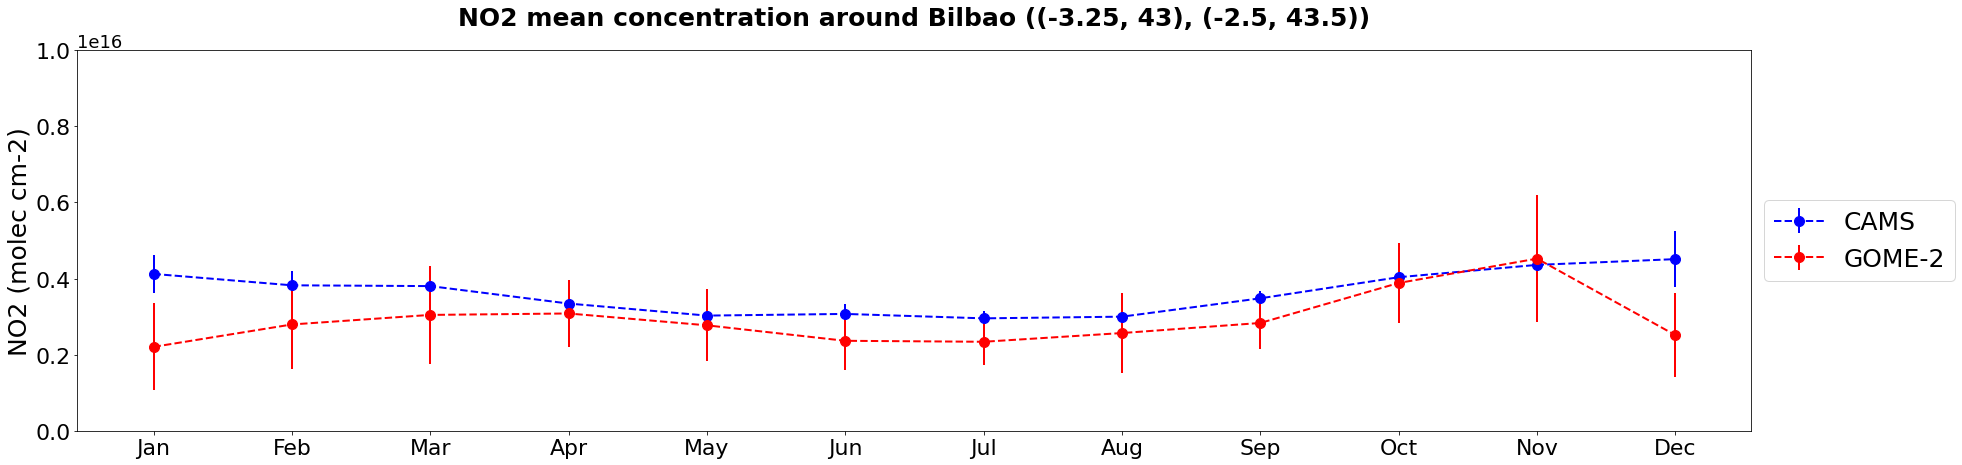

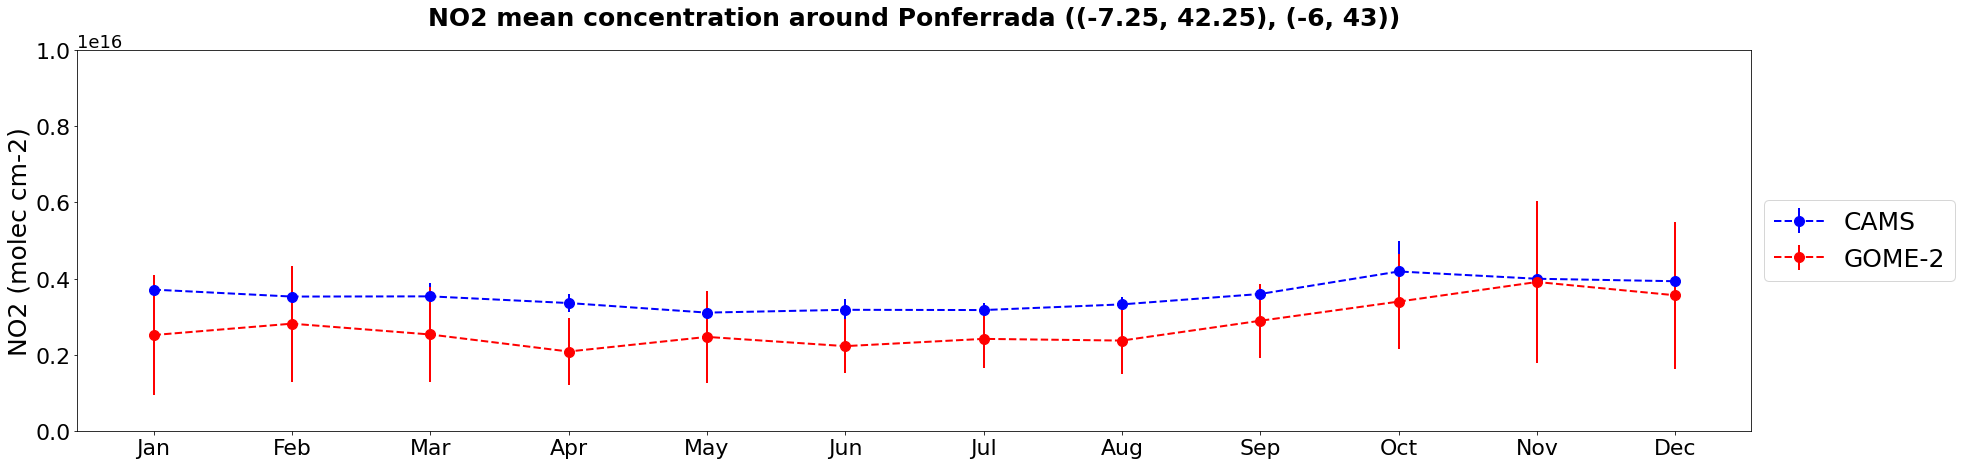

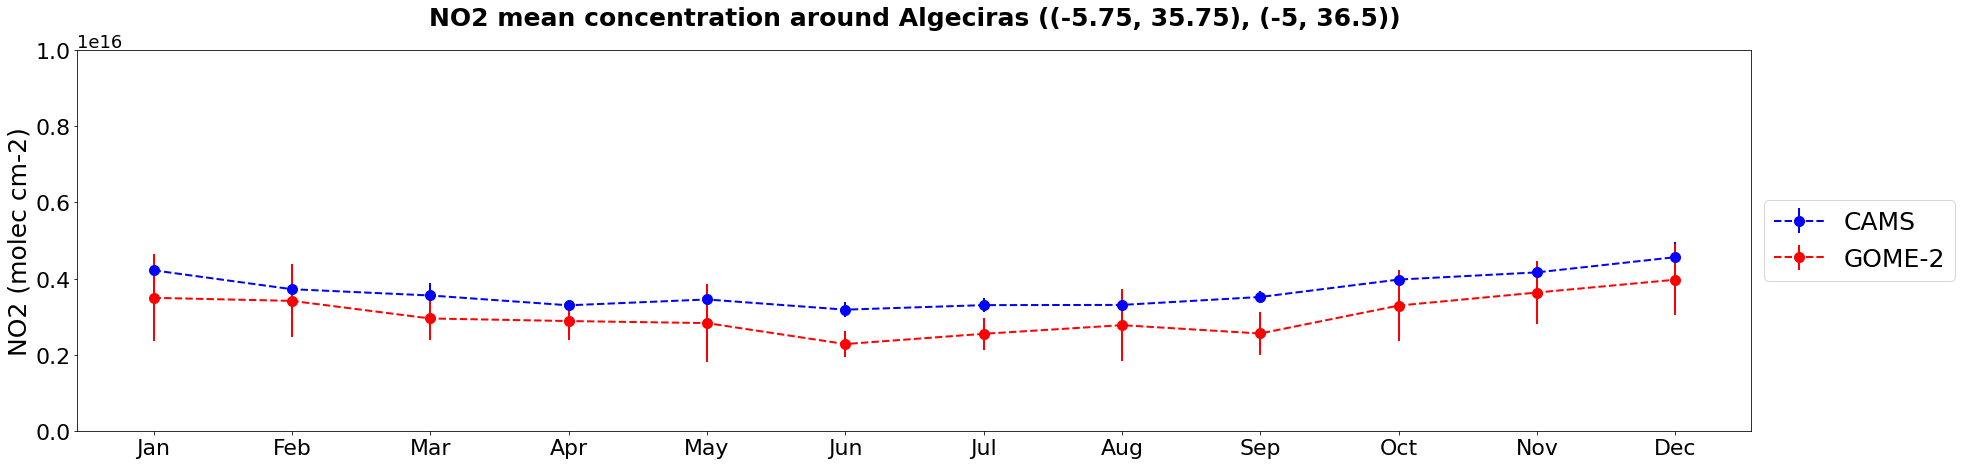

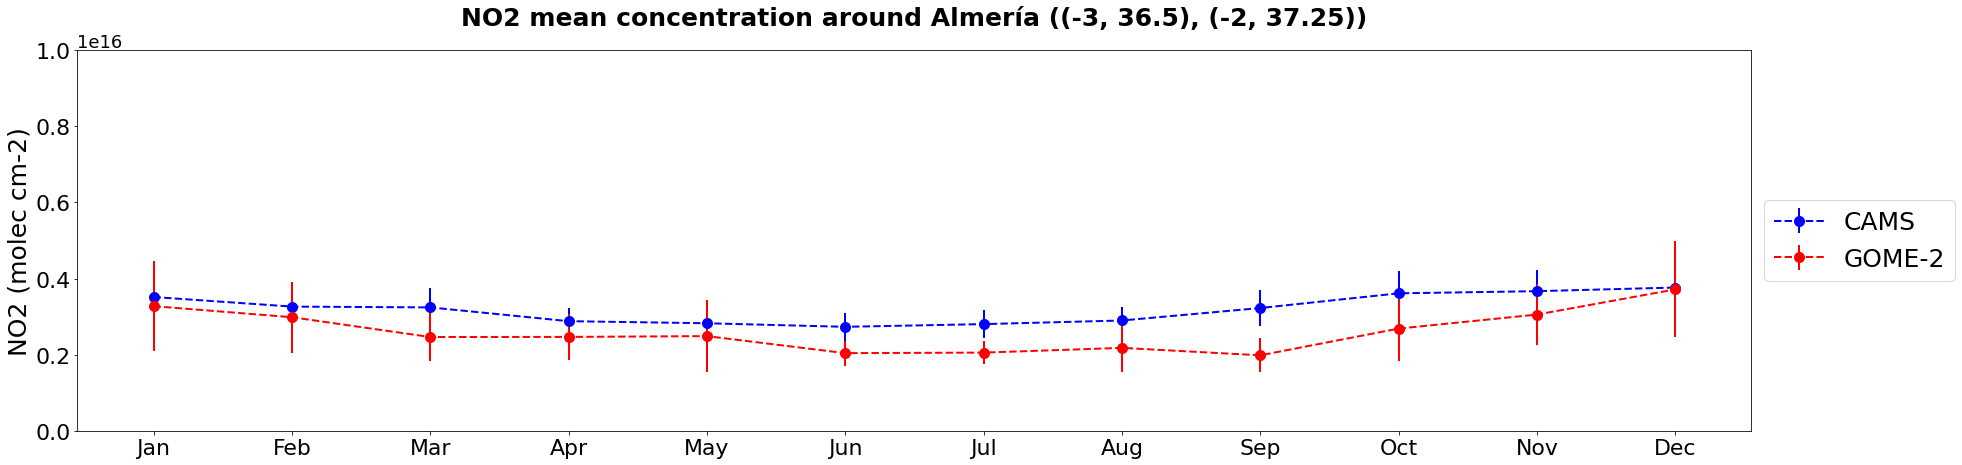

location  month    model mean     model std   sensor mean    sensor std
0   Barcelona      1  6.752575e+15  1.475241e+15  5.046309e+15  1.129722e+15
1   Barcelona      2  5.622621e+15  1.021770e+15  5.373767e+15  1.149372e+15
2   Barcelona      3  4.967279e+15  5.273055e+14  4.855100e+15  9.206757e+14
3   Barcelona      4  4.052381e+15  3.330428e+14  4.454833e+15  1.089883e+15
4   Barcelona      5  3.608182e+15  2.471239e+14  4.171900e+15  1.294445e+15
..        ...    ...           ...           ...           ...           ...
7     Almería      8  2.898966e+15  3.448269e+14  2.179375e+15  6.453455e+14
8     Almería      9  3.226834e+15  4.854912e+14  1.984000e+15  4.443849e+14
9     Almería     10  3.612951e+15  5.860332e+14  2.686500e+15  8.450294e+14
10    Almería     11  3.669421e+15  5.617958e+14  3.054625e+15  8.010207e+14
11    Almería     12  3.765038e+15  9.289103e+14  3.716708e+15  1.263745e+15

[72 rows x 6 columns]

In [21]:
regions_names = ('Barcelona', 'Madrid', 'Bilbao', 'Ponferrada', 'Algeciras', 'Almería')
bbox_list = (41, 41.75, 1.5, 2.75,
             40, 40.75, -4.25, -3,
             43, 43.5, -3.25, -2.5,
             42.25, 43, -7.25, -6,
             35.75, 36.5, -5.75, -5,
             36.5, 37.25, -3, -2)
ymin = 0
ymax = 1*10**16
monthly_annual_cycle_table = monthly_annual_cycle(merge_df, component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

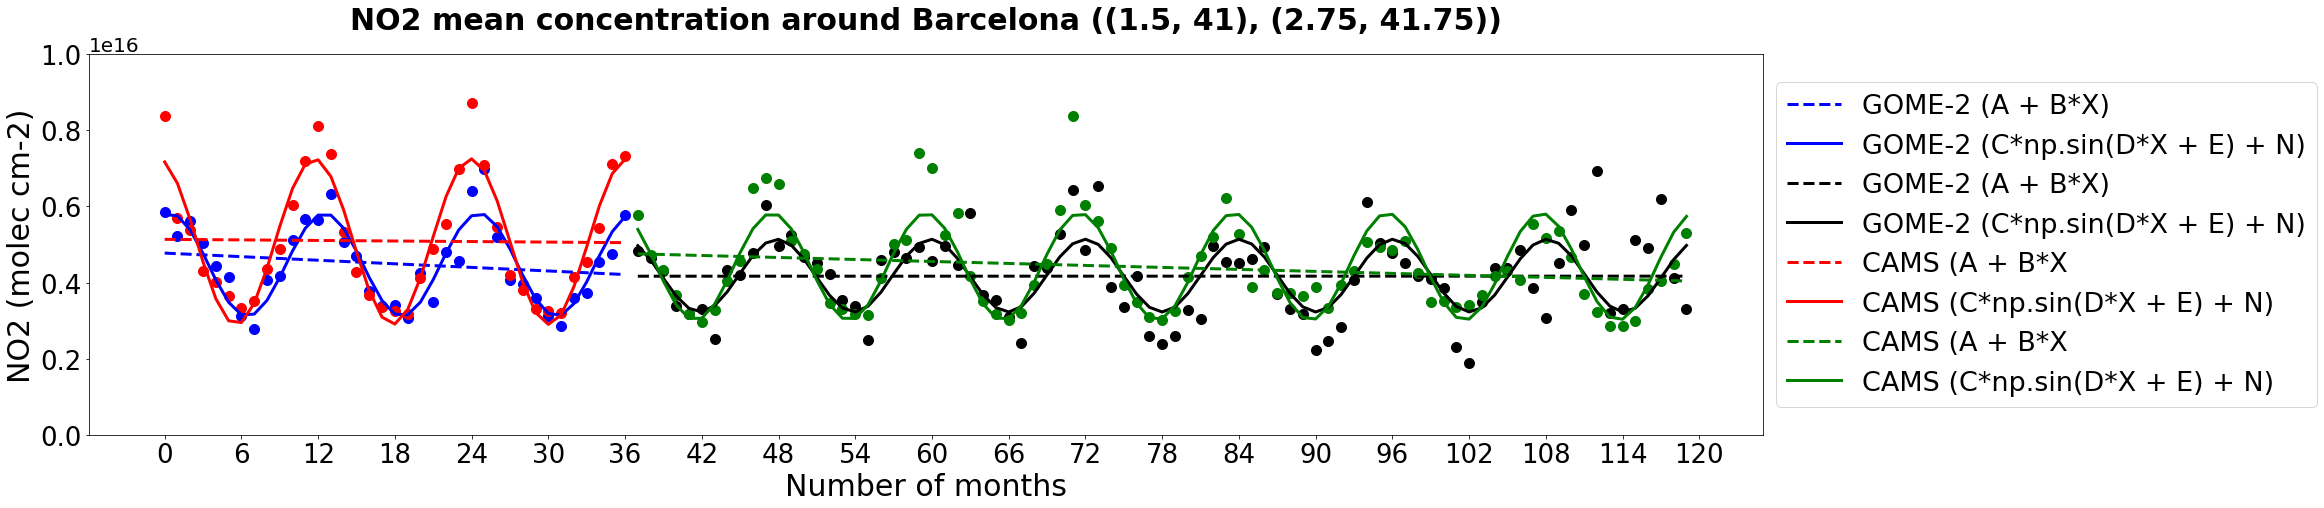

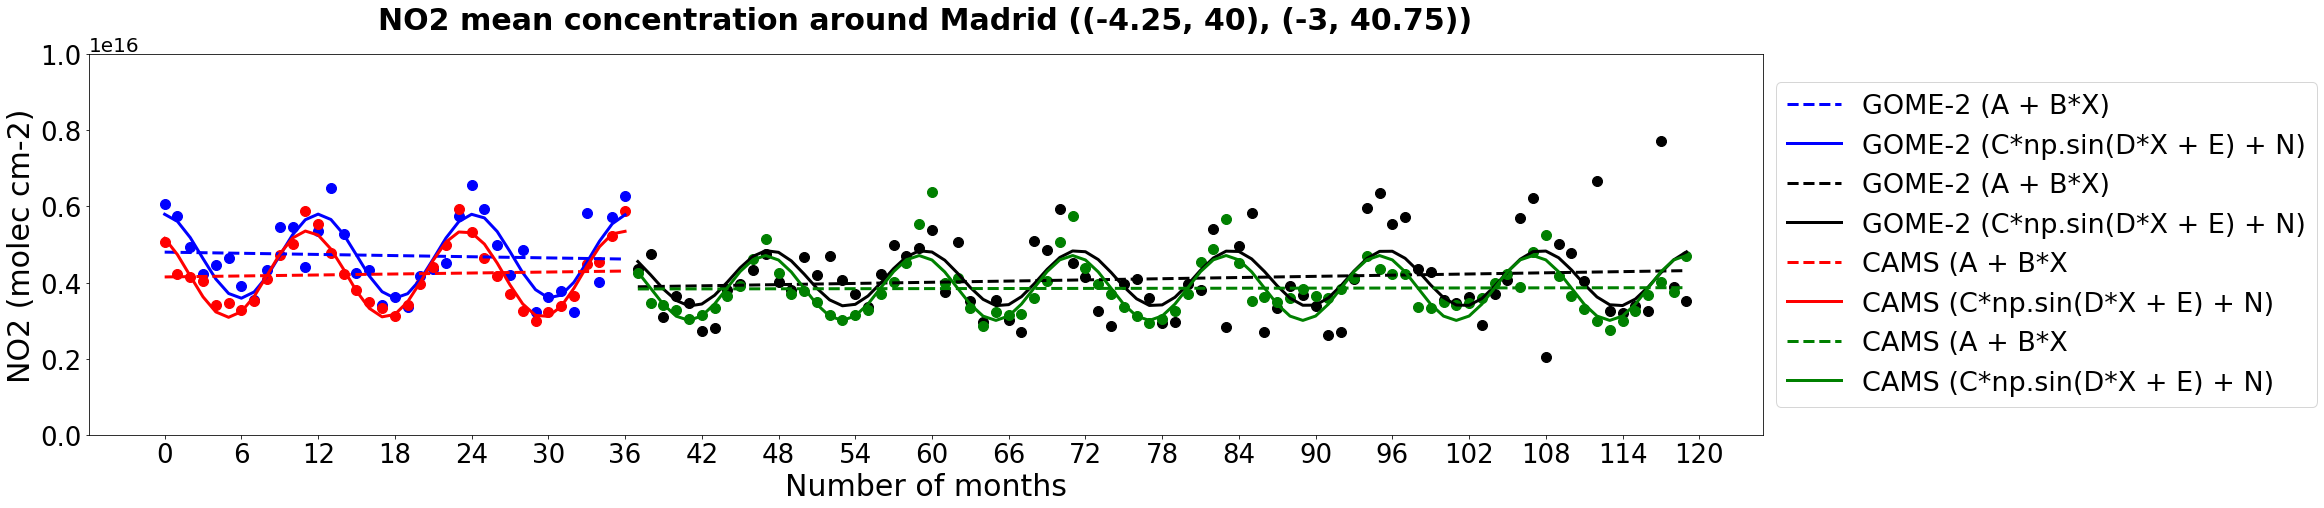

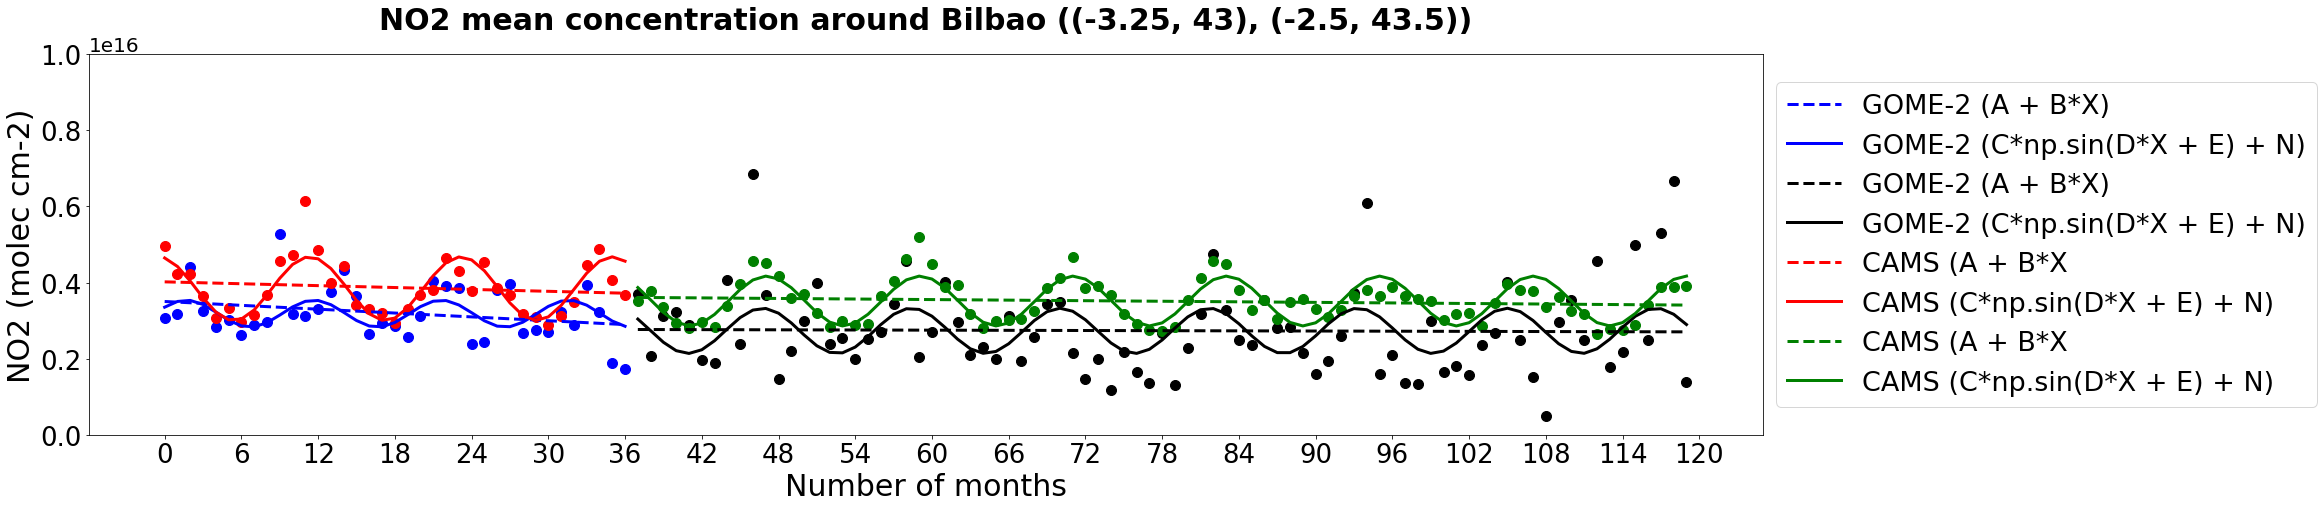

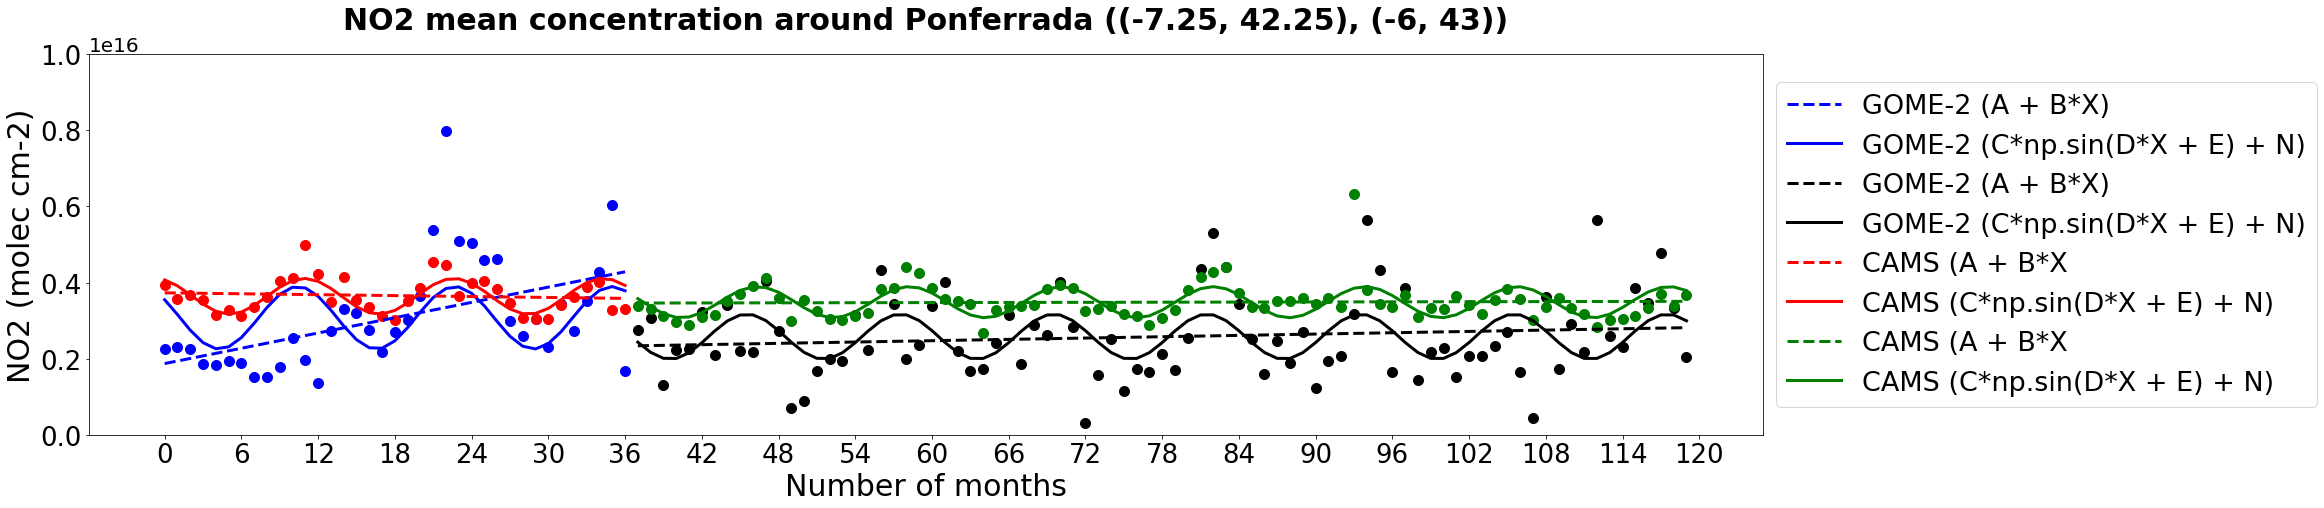

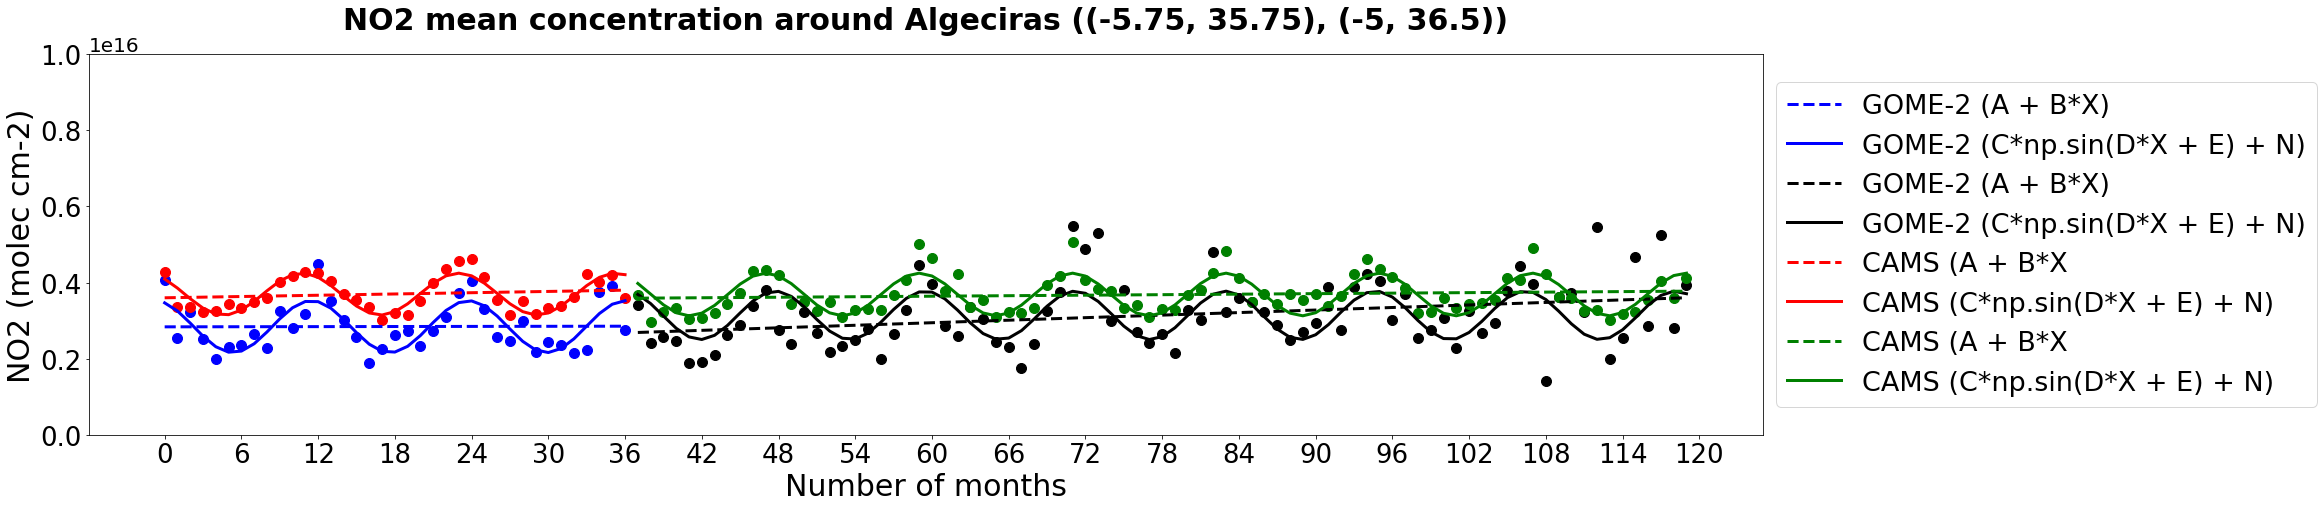

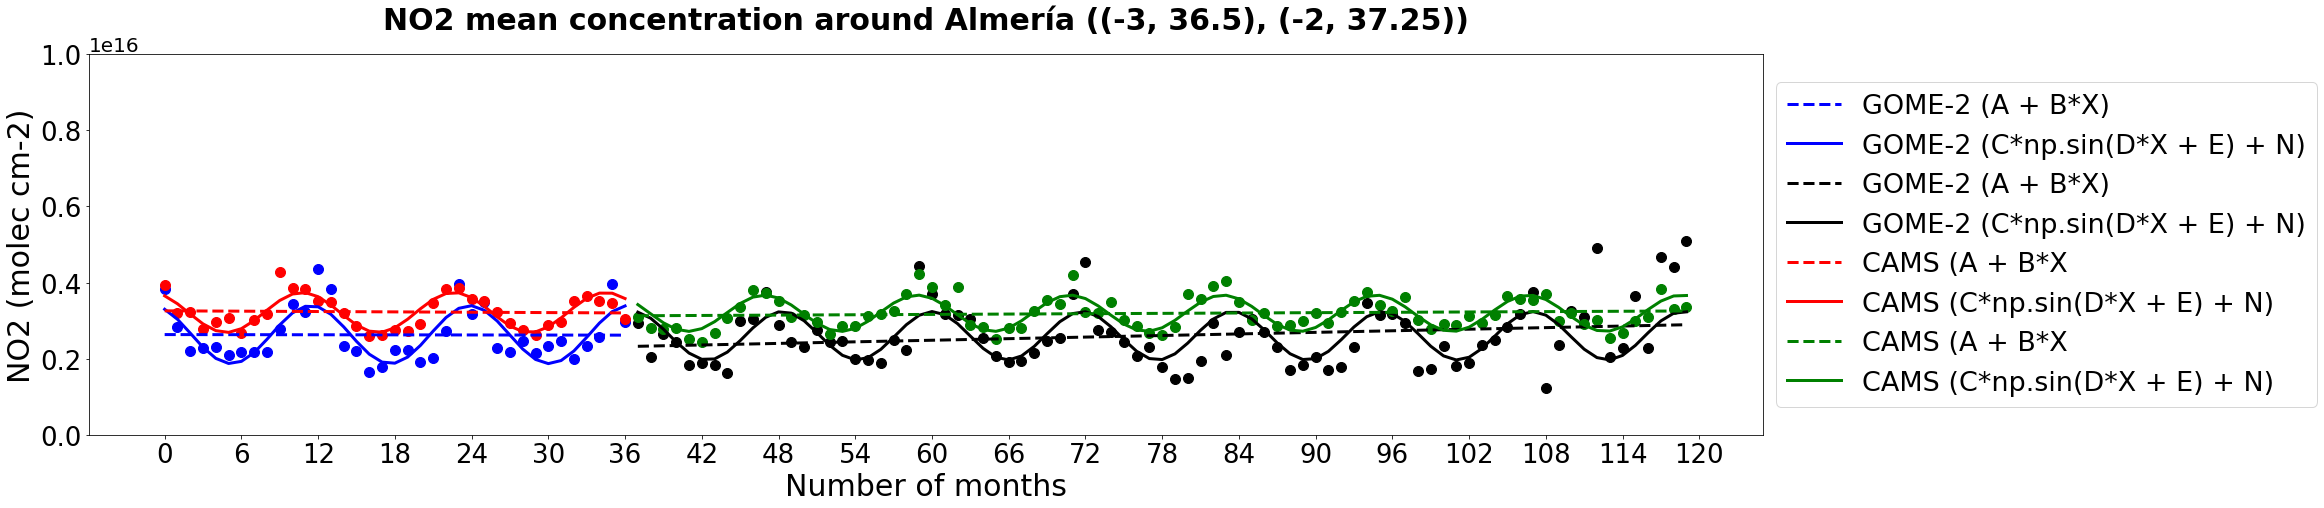

Location    Source  Rate (molec cm-2 y-1)  Rate (% y-1)             A  \
0   Barcelona  Sensor-1          -1.879412e+14     -3.935650  4.775353e+15   
1   Barcelona  Sensor-2           2.158360e+11      0.005178  4.167367e+15   
2   Barcelona   Model-1          -2.896986e+13     -0.564003  5.136469e+15   
3   Barcelona   Model-2          -1.044917e+14     -2.197185  5.077891e+15   
0      Madrid  Sensor-1          -6.069986e+13     -1.264422  4.800599e+15   
1      Madrid  Sensor-2           6.209750e+13      1.596330  3.698550e+15   
2      Madrid   Model-1           5.169824e+13      1.246246  4.148318e+15   
3      Madrid   Model-2           4.888486e+12      0.127544  3.817697e+15   
0      Bilbao  Sensor-1          -2.023442e+14     -5.775848  3.503282e+15   
1      Bilbao  Sensor-2          -9.089795e+12     -0.328469  2.795352e+15   
2      Bilbao   Model-1          -9.935084e+13     -2.471822  4.019336e+15   
3      Bilbao   Model-2          -2.940556e+13     -0.814549  3.700711e+15   
0  Ponferrada  Sensor-1           8.036567e+14     42.923530  1.872299e+15   
1  Ponferrada  Sensor-2           6.968584e+13      2.978855  2.124485e+15   
2  Ponferrada   Model-1          -4.837639e+13     -1.296783  3.730493e+15   
3  Ponferrada   Model-2           6.578388e+12      0.190017  3.441714e+15   
0   Algeciras  Sensor-1           5.670934e+12      0.199886  2.837079e+15   
1   Algeciras  Sensor-2           1.334036e+14      4.960251  2.278124e+15   
2   Algeciras   Model-1           6.676101e+13      1.854121  3.600682e+15   
3   Algeciras   Model-2           2.693496e+13      0.750185  3.507393e+15   
0     Almería  Sensor-1          -5.078236e+12     -0.192801  2.633924e+15   
1     Almería  Sensor-2           8.295547e+13      3.566697  2.070055e+15   
2     Almería   Model-1          -1.854741e+13     -0.569285  3.258019e+15   
3     Almería   Model-2           1.836781e+13      0.587086  3.072009e+15   

              B             C         D         E             N     Linear R2  \
0 -1.566177e+13  1.351088e+15  0.519735  1.359357  4.467613e+15  2.499188e-02   
1  1.798633e+10  9.559548e+14  0.521802  1.716489  4.183506e+15  1.591236e-07   
2 -2.414155e+12  2.176307e+15  0.513283  1.847999  5.076653e+15  2.487295e-04   
3 -8.707643e+12 -1.405187e+15  0.522382 -1.249610  4.418326e+15  3.321366e-02   
0 -5.058321e+12  1.104954e+15  0.516546  1.650035  4.694256e+15  3.182186e-03   
1  5.174792e+12 -7.328093e+14  0.521026 -1.071172  4.113985e+15  1.360565e-02   
2  4.308186e+12 -1.134983e+15  0.510949 -0.978223  4.222716e+15  2.971755e-03   
3  4.073738e+11 -8.523666e+14  0.523486 -1.034693  3.858504e+15  1.841684e-04   
0 -1.686202e+13 -3.541391e+14  0.630638 -2.641698  3.183921e+15  6.548293e-02   
1 -7.574829e+11 -5.943317e+14  0.539609 -1.664657  2.732015e+15  2.315762e-04   
2 -8.279237e+12 -8.378198e+14  0.530840 -1.302467  3.839641e+15  1.504807e-02   
3 -2.450464e+12 -6.553295e+14  0.524206 -1.116657  3.515838e+15  1.146620e-02   
0  6.697139e+13 -8.213083e+14  0.511617 -0.615043  3.075184e+15  2.503517e-01   
1  5.807154e+12 -5.915909e+14  0.523811 -0.284816  2.579269e+15  1.620852e-02   
2 -4.031366e+12 -4.701505e+14  0.537722 -1.162554  3.639087e+15  8.800409e-03   
3  5.481990e+11 -4.094309e+14  0.528904 -0.950260  3.484875e+15  7.580918e-04   
0  4.725778e+11 -6.815774e+14  0.511778 -1.160115  2.842510e+15  6.273885e-05   
1  1.111696e+13 -6.360615e+14  0.535608 -2.010886  3.139280e+15  9.278372e-02   
2  5.563417e+12 -5.505730e+14  0.512932 -0.803237  3.697654e+15  1.772171e-02   
3  2.244580e+12 -5.606058e+14  0.524368 -1.095760  3.687578e+15  1.203105e-02   
0 -4.231863e+11 -7.625200e+14  0.505382 -1.063291  2.632401e+15  4.366605e-05   
1  6.912956e+12 -6.367148e+14  0.535604 -2.315444  2.602601e+15  4.090818e-02   
2 -1.545617e+12 -5.258970e+14  0.529453 -0.979338  3.215129e+15  1.442382e-03   
3  1.530651e+12 -4.774014e+14  0.525893 -1.106345  3.194335e+15  8.036499e-03   

    Linear RMSE    Linear MS

In [22]:
regions_names = ('Barcelona', 'Madrid', 'Bilbao', 'Ponferrada', 'Algeciras', 'Almería')
bbox_list = (41, 41.75, 1.5, 2.75,
             40, 40.75, -4.25, -3,
             43, 43.5, -3.25, -2.5,
             42.25, 43, -7.25, -6,
             35.75, 36.5, -5.75, -5,
             36.5, 37.25, -3, -2)
ymin = 0
ymax = 1*10**16
sensor_break_date = '2013-01-01' # None or date as a string
model_break_date = '2013-01-01' # None or date as a string

trends_table = trends(merge_df, component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

Frame length between -10 and 5 should be one of these options: [1, 3, 5, 15]
Frame length between 35 and 45 should be one of these options: [1, 2, 5, 10]


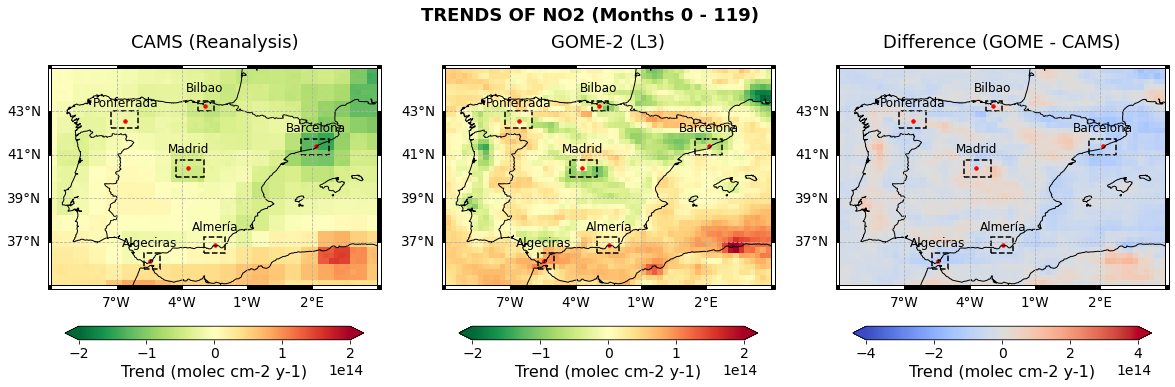

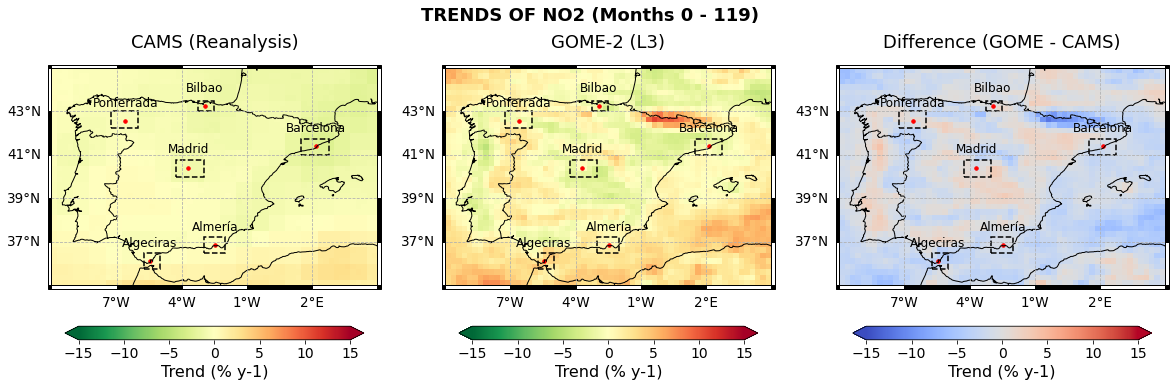

In [24]:
# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['RdYlGn_r', 'RdYlGn_r', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 3
height_lat = 2

# Define break dates (None or both the same)
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

# Define range
vmax_manual_rate_units, vmin_manual_rate_units = 0.2*10**15, -0.2*10**15
vmax_manual_diff_units, vmin_manual_diff_units = 0.4*10**15, -0.4*10**15
vmax_manual_rate_100, vmin_manual_rate_100 = 15, -15
vmax_manual_diff_100, vmin_manual_diff_100 = 15, -15

bbox_trends_table = visualize_bbox_trends(merge_df, component_nom, sensor, model, units, plot_dates, 
                                          sensor_break_date, model_break_date, 20, 1.05,
                                          vmin_manual_rate_units, vmax_manual_rate_units, 
                                          vmin_manual_rate_100, vmax_manual_rate_100,
                                          vmin_manual_diff_units, vmax_manual_diff_units, 
                                          vmin_manual_diff_100, vmax_manual_diff_100,
                                          width_lon, height_lat, bbox_list, coords_list, regions_names)

## 10. Scatter plots by bbox

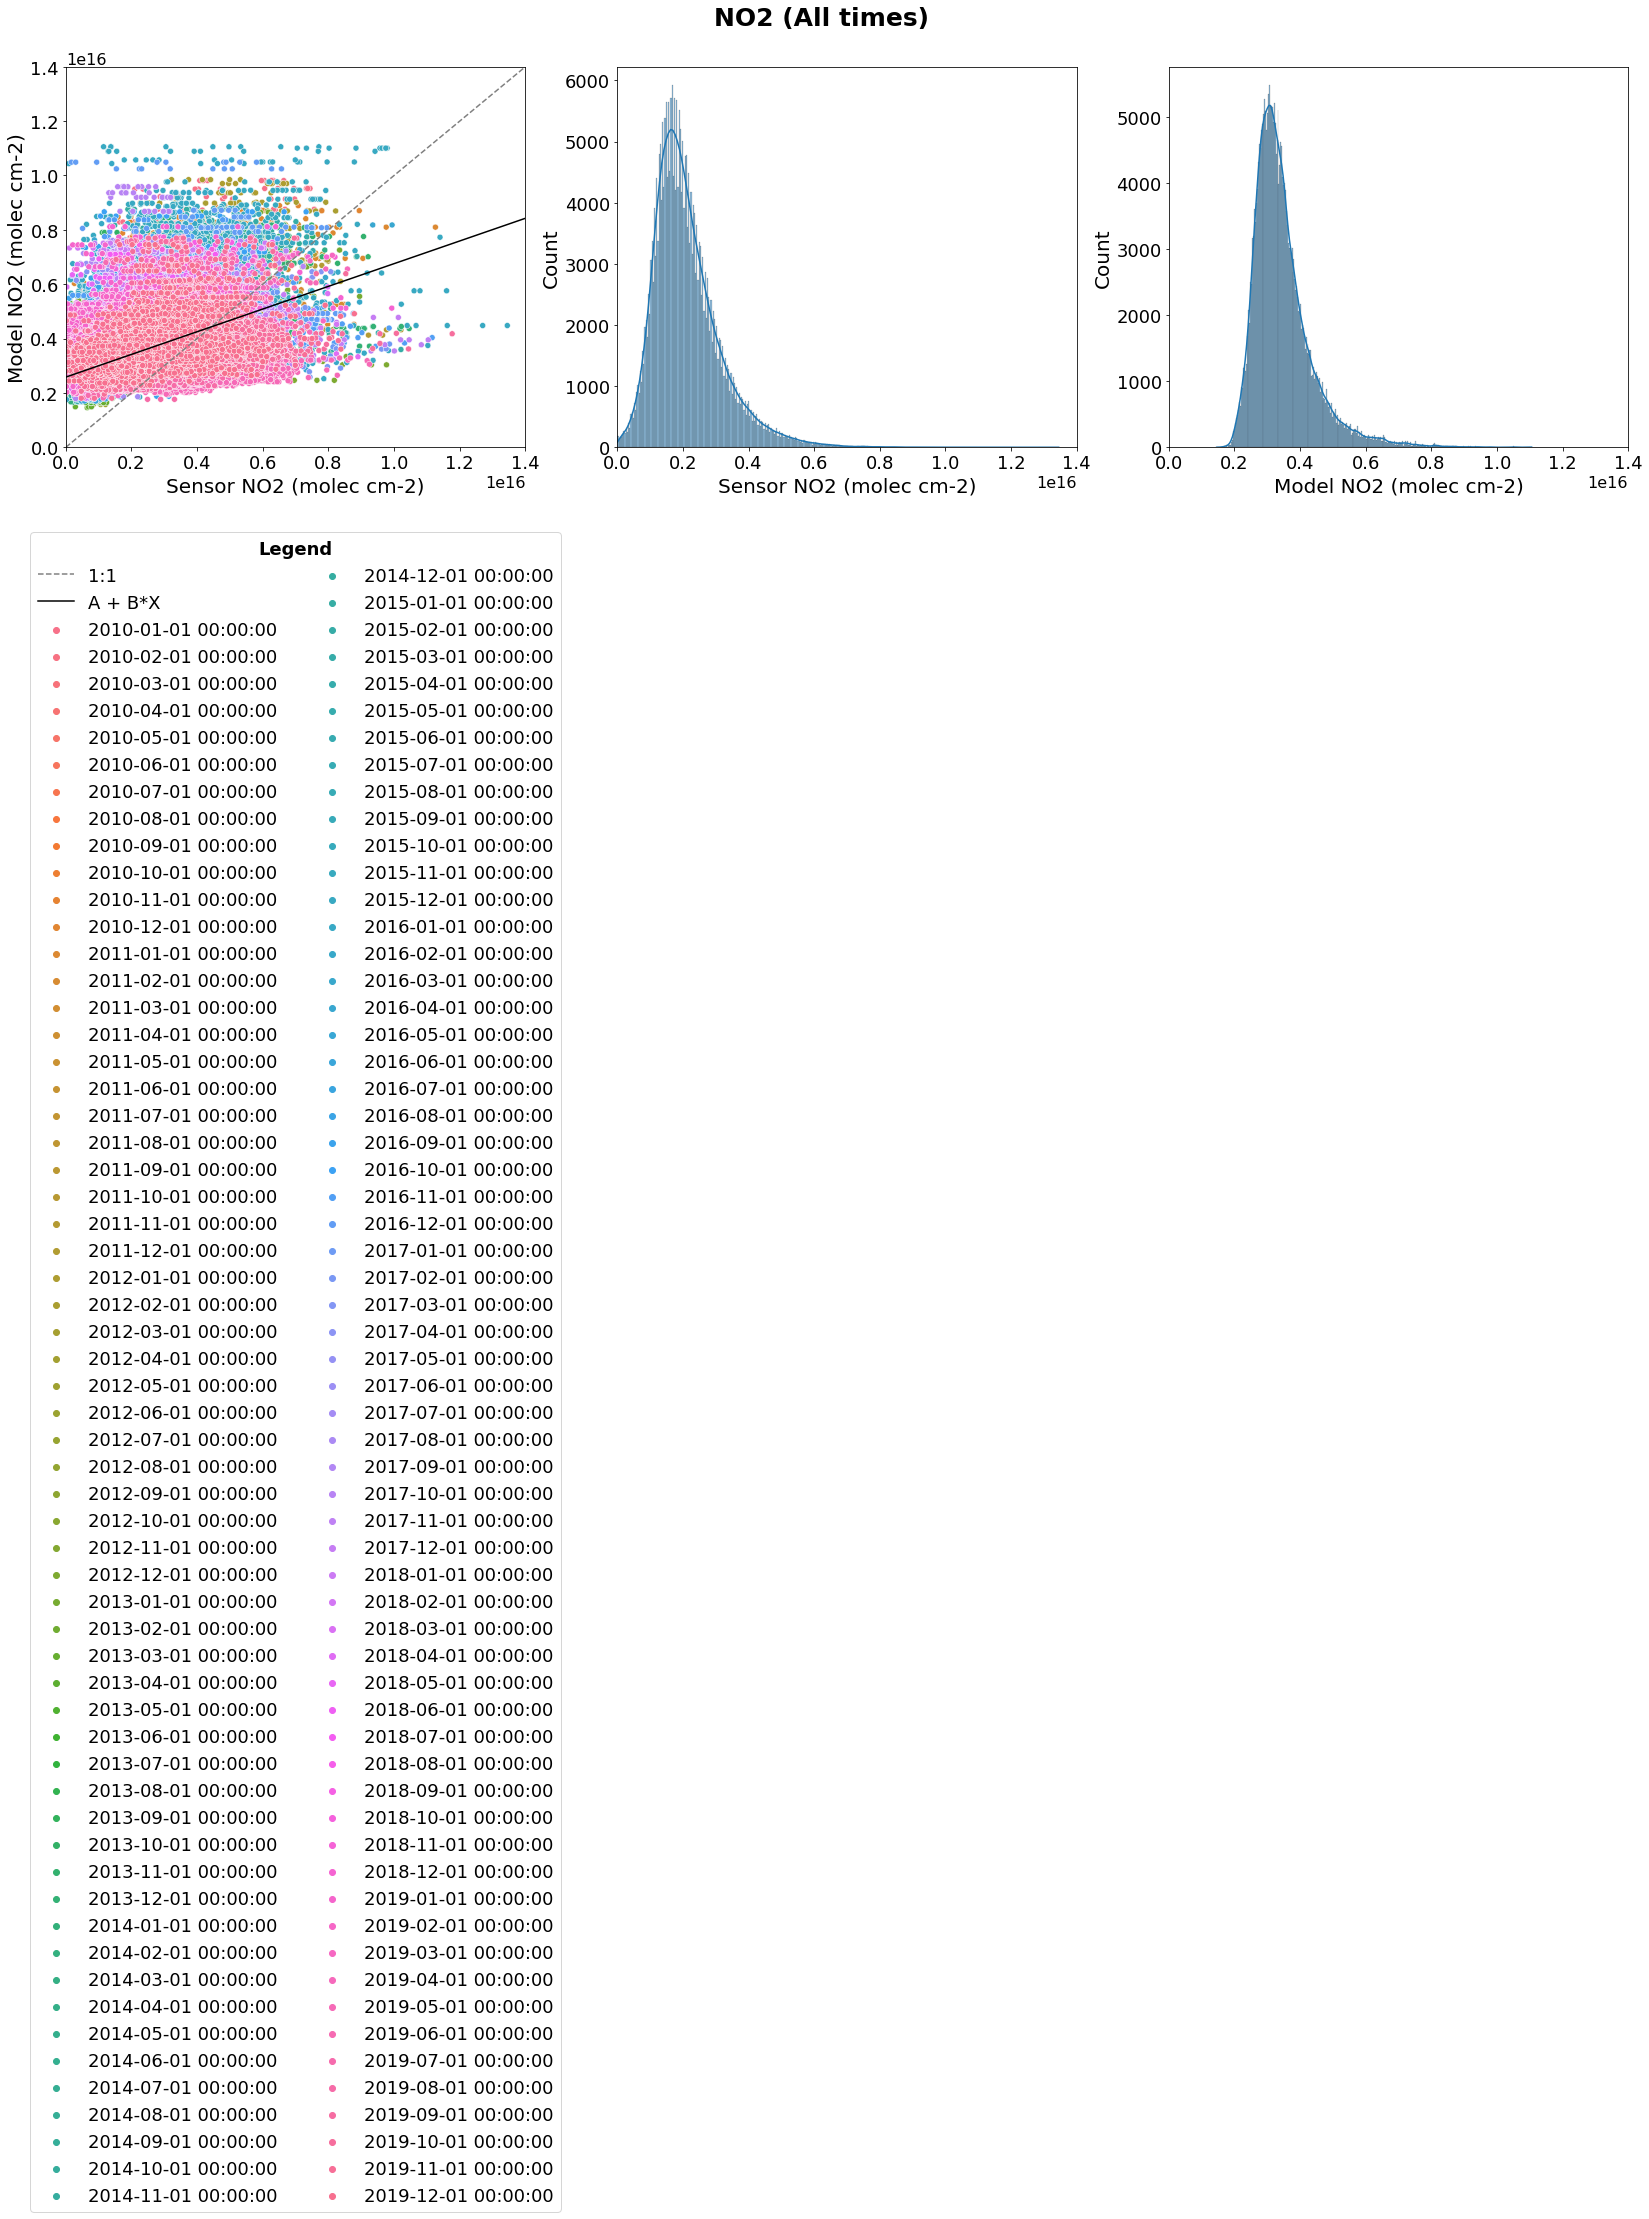

Period              Location  \
0  [2010-01-01T00:00:00.000000000, 2010-02-01T00:...  ((-10, 35), (5, 45))   

         A             B        R2          RMSE           MSE  
0  0.41733  2.582836e+15  0.227422  7.951595e+14  6.322787e+29

In [26]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 1.4*10**16

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, extent_definition, 
                       show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

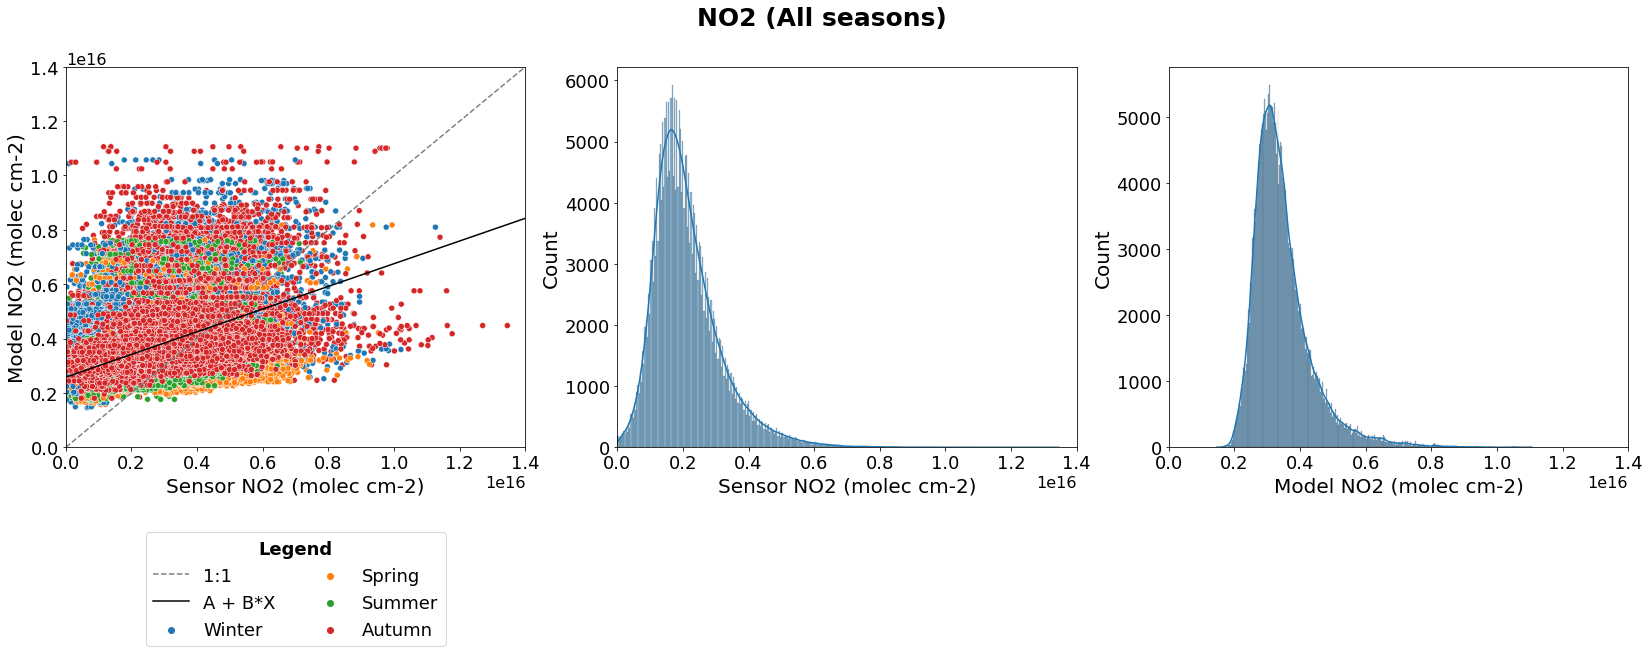

Period              Location        A  \
0  [Autumn, Spring, Summer, Winter]  ((-10, 35), (5, 45))  0.41733   

              B        R2          RMSE           MSE  
0  2.582836e+15  0.227422  7.951595e+14  6.322787e+29

In [27]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 1.4*10**16

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, extent_definition, 
                       show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['China', 'India', 'Vietnam']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, extent_definition, 
                       show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['China', 'India', 'Vietnam']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, extent_definition, \n                       show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"